## Sommaire :

* [**1.Problem setup**](#0)
    * [1.1. BS market model](#1_1)
    * [1.2. American payoff](#1_2)
    * [1.3. Snell enveloppe and supermartingale structure](#1_3)

* [**2.Regression method : Longstaff Schwartz, primal and dual**](#1)
    * [2.1. BS dynamics](#1_1)
    * [2.2. Backward Induction: Longstaff–Schwartz : lower bound](#1_2)
    * [2.3. Convergence graphe control variate](#1_3)
    * [2.4. Backward Induction: Longstaff–Schwartz : Anderson Broadie formulation, Upper bound](#1_4)
    * [2.5. Convergence graphe LSM vs AB](#1_5)

* [**3. PDE**](#2)
    * [3.1. ...](#2_1)
    * [3.2. ...](#2_2)
    * [3.3. ...](#2_3)


<a id='0'></a>
# 1. Problem setup :

We work on a filtered probability space  
$(\Omega,\mathcal{F}, (\mathcal{F}_t)_{0\le t\le T},\mathbb{Q})$  
satisfying the usual conditions.  
All pricing will be conducted under the **risk-neutral measure** $\mathbb{Q}$.

---

## 1.1 Black–Scholes Market Model

We consider a single risky asset $S$ whose dynamics under $\mathbb{Q}$ is:

$$
dS_t = r S_t\,dt + \sigma S_t\, dW_t,
$$

where  
- $r$ is the constant short rate,  
- $\sigma>0$ the constant volatility,  
- $(W_t)$ a standard Brownian motion under $\mathbb{Q}$.

The **discount factor** is:

$$
D(t,T) = e^{-r(T-t)}.
$$

The **discounted stock price**  
$\tilde S_t = D(0,t) S_t$  
satisfies:

$$
d\tilde S_t = \sigma \tilde S_t\, dW_t,
$$

so $(\tilde S_t)$ is a **$\mathbb{Q}$-martingale**.  
This property is what allows Monte Carlo pricing.

---

## 1.2 American Put Payoff

We study the American **put** with strike $K$ and maturity $T$.  
If the holder exercises at time $t$, the payoff is:

$$
G_t = (K - S_t)_+.
$$

We define its **discounted payoff process**:

$$
\tilde G_t = \beta_t G_t = e^{-rt}(K - S_t)_+.
$$

The American option price is:

$$
P_0 = \sup_{\tau \in \mathcal{T}} 
\mathbb{E}^{\mathbb{Q}}[\tilde G_\tau],
$$

where $\mathcal{T}$ is the set of stopping times valued in $[0,T]$.

This is the **optimal stopping formulation**, common to:
- Monte Carlo backward induction (LSM, Andersen–Broadie, etc.),
- PDE variational inequalities (free boundary),
- dual formulations (Glasserman 8.7).

---

## 1.3 Snell Envelope and Supermartingale Structure

A fundamental fact (Lamberton–Lapeyre, Glasserman 8.1) is:

> The discounted value process of any American option is the **Snell envelope**  
> of the discounted payoff.

### Snell Envelope  
Define:

$$
Y_t = \operatorname*{ess\,sup}_{\tau\in\mathcal{T}_t}
\mathbb{E}^{\mathbb{Q}}[\tilde G_\tau \mid \mathcal{F}_t].
$$

Then:

- $(Y_t)$ is a **$\mathbb{Q}$-supermartingale**,  
- $Y_t \ge \tilde G_t$ for all $t$,  
- $Y$ is the *smallest* supermartingale dominating $\tilde G$.

A process $(Y_t)$ is a **supermartingale** if:

$$
\mathbb{E}[Y_t \mid \mathcal{F}_s] \le Y_s
\quad (s \le t).
$$

Intuition:
- **Discounted continuation values cannot increase in expectation**.
- This makes early-exercise analysis compatible with dynamic programming.

### Optimal Exercise Time

Define the first hitting time:

$$
\tau^\star = \inf\{t : Y_t = \tilde G_t\}.
$$

Then $\tau^\star$ is an **optimal stopping time** and:

$$
P_0 = Y_0 = \mathbb{E}^{\mathbb{Q}}[\tilde G_{\tau^\star}].
$$

This structure is exactly what underlies:
- regression Monte Carlo (LSM): approximation of $Y_t$ from below,
- dual Monte Carlo (Andersen–Broadie): construction of upper bounds via martingales,
- PDE free boundary: region where $Y_t = \tilde G_t$.


In [38]:
# Modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import time
from math import log, sqrt, exp, erf
from dataclasses import dataclass, field
from typing import Optional, List, Tuple, Dict, Any

<a id='1'></a>
# 2. Regression methods :

<a id='1_1'></a>
## 2.1 BS dynamics :


Sous $\mathbb{Q}$, la dynamique de $\mathcal{S}$ s'écrit :

$$
\frac{dS_t}{S_t} = r \, dt + \sigma \, dW_t
$$

**Solution de l'EDS :** (Pas de schéma nécessaire)

$$
d(\ln(S_t)) = \frac{1}{S_t} dS_t - \frac{1}{2} \frac{1}{S_t^2} (dS_t)^2
\implies d(\ln(S_t)) = \frac{1}{S_t} \big(S_t (r  \, dt + \sigma \, dW_t)\big) - \frac{1}{2} \sigma^2 dt
\implies d(\ln(S_t)) = \left(r  - \frac{1}{2} \sigma^2\right) dt + \sigma dW_t
$$

$$
\ln(S_t) = \ln(S_0) + \left(r  - \frac{1}{2} \sigma^2\right)t + \sigma W_t
\implies S_t = S_0 \exp\left(\left(r  - \frac{1}{2} \sigma^2\right)t + \sigma W_t\right)
$$


$$
\implies S_{t_k} = S_{t_{k-1}} \exp\left(\left(r  - \frac{1}{2} \sigma^2\right)(t_k - t_{k-1}) + \sigma \left(W_{t_k} - W_{t_{k-1}}\right)\right)
$$



$$
\implies
\boxed{ \ln \Big(\tfrac{S_{t_k}}{S_{t_{k-1}}}\Big) \,\big|\, \mathcal{F}_s 
\sim \mathcal{N}\!\Big( \big(r-\tfrac12\sigma^2\big)(t_k - t_{k-1}),\; \sigma^2(t_k - t_{k-1}) \Big) }
$$

---

In [39]:
# =============================================================================
#                         BLACK–SCHOLES MODEL
# =============================================================================

@dataclass
class BlackScholes:
    """
    Black–Scholes model under the risk-neutral measure 𝒬.
    """

    S0: float
    r: float
    sigma: float
    q: float = 0.0

    # -------------------------------------------------------------------------
    def simulate_paths(
        self,
        T: float,
        n_steps: int,
        n_paths: int,
        seed: Optional[int] = None
    ) -> np.ndarray:
        """
        Simulate GBM paths {S_t} under the risk-neutral measure 𝒬.
        """
        rng = np.random.default_rng(seed)
        dt   = T / n_steps
        drift = ((self.r - self.q) - 0.5 * self.sigma**2) * dt
        vol   = self.sigma * np.sqrt(dt)

        paths = np.zeros((n_paths, n_steps + 1))
        paths[:, 0] = self.S0

        for t in range(1, n_steps + 1):
            z = rng.standard_normal(n_paths)
            paths[:, t] = paths[:, t - 1] * np.exp(drift + vol * z)

        return paths

    # -------------------------------------------------------------------------
    def _norm_cdf(self, x: float) -> float:
        """Standard normal CDF Φ(x)."""
        return 0.5 * (1.0 + erf(x / sqrt(2.0)))

    # -------------------------------------------------------------------------
    def price_bs_closed_form(
        self,
        K: float,
        T: float,
        type: str = "call"
    ) -> float:
        """
        Black–Scholes closed-form price (European option).
        """

        d1 = (
            log(self.S0 / K)
            + (self.r - self.q + 0.5 * self.sigma**2) * T
        ) / (self.sigma * sqrt(T))
        d2 = d1 - self.sigma * sqrt(T)

        disc_r = exp(-self.r * T)
        disc_q = exp(-self.q * T)

        if type == "call":
            return (
                self.S0 * disc_q * self._norm_cdf(d1)
                - K * disc_r * self._norm_cdf(d2)
            )
        else:
            return (
                K * disc_r * self._norm_cdf(-d2)
                - self.S0 * disc_q * self._norm_cdf(-d1)
            )

<a id='1_2'></a>
## 2.2 Backward Induction: Longstaff–Schwartz, Lower bound

### Problem formulation

The risk–neutral price of an American option can be written as an optimal stopping problem:
$$
P_0 = \sup_{\tau \in \mathcal T} \mathbb{E}^{\mathbb{Q}}\big[\tilde G_\tau\big],
$$
where $\mathcal T$ is the set of stopping times taking values in the exercise dates
$\{t_0,\dots,t_M\}$, and $\tilde G_t$ is the discounted payoff.

---

### Dynamic programming (DPP)

On the discrete exercise grid, the value function satisfies the backward recursion:
$$
V_M(x) = \tilde G_M(x),
$$
$$
V_i(x) =
\max\Big(
G_i(x),\;
\mathbb{E}\big[e^{-r\Delta t}\,V_{i+1}(S_{t_{i+1}})
\mid S_{t_i}=x\big]
\Big),
\quad i=M-1,\dots,0.
$$

- $G_i(x)$: immediate exercise value,
- conditional expectation: continuation value.

The initial price is $P_0 = V_0(S_{t_0})$.

---

### Optimal stopping rule

The DPP induces a local decision rule:
- exercise at $t_i$ if
$$
G_i(S_{t_i}) \ge
\mathbb{E}\big[e^{-r\Delta t}\,V_{i+1}(S_{t_{i+1}})
\mid S_{t_i}\big],
$$
- otherwise continue.

This defines the optimal stopping time:
$$
\tau^\star = \inf\{t_i : G_i(S_{t_i}) = V_i(S_{t_i})\},
$$
which is a stopping time since the decision uses only current information.

---

### Longstaff–Schwartz approximation

In the Longstaff–Schwartz (LSM) algorithm, the continuation value is approximated by regression:
$$
\widehat C_i(x) \approx
\mathbb{E}\big[e^{-r\Delta t}\,V_{i+1}(S_{t_{i+1}})
\mid S_{t_i}=x\big].
$$

The approximate value function is
$$
\widehat V_i(x) = \max\big(G_i(x),\;\widehat C_i(x)\big),
$$
and the induced stopping rule is
$$
\tau_{\text{LSM}}
=
\inf\{t_i : G_i(S_{t_i}) \ge \widehat C_i(S_{t_i})\}.
$$

---

### Interpretation of parameters $\theta$

In LSM, the continuation value is parametrized as
$$
\widehat C_i(x;\theta) = \sum_k \beta_{i,k}\,\phi_k(x),
$$
where $\phi_k$ are basis functions.

- $\theta$ collects all regression coefficients,
- $\theta$ defines the **shape of the continuation value**,
- the exercise rule follows automatically from the comparison
$$
G(S_{t_i}) \ge \widehat C_i(S_{t_i};\theta).
$$

The resulting estimator provides a **lower bound** on the American option price.


In [40]:
# =============================================================================
#            PRICING ENGINE — LONGSTAFF–SCHWARTZ (LOW)
# =============================================================================

class PricingEngine:
    def __init__(self, model):
        """
        Parameters
        ----------
        model : BlackScholes (ou objet équivalent)
            Doit fournir:
              - simulate_paths(T, n_steps, n_paths, seed) -> array (n_paths, n_steps+1)
              - r (taux sans risque)
              - price_bs_closed_form(K, T, type) -> float (prix européen BS)
        """
        self.model = model

    # -------------------------------------------------------------------------
    def simulate_paths(self, T, n_steps, n_paths, seed=None):
        return self.model.simulate_paths(T, n_steps, n_paths, seed)

    # =========================================================================
    #                        LOW ESTIMATOR (LSM CLASSIQUE)
    # =========================================================================
    def price_american_LSM_low(
        self,
        K: float,
        T: float,
        n_steps: int,
        n_paths: int,
        type: str = "put",
        basis: str = "poly2",
        control_variate: bool = False,
        seed: Optional[int] = None,
    ) -> float:
        """
        Price an American option using the Longstaff–Schwartz algorithm (LOW estimator).
        """

        S = self.simulate_paths(T, n_steps, n_paths, seed)
        dt = T / n_steps
        disc = np.exp(-self.model.r * dt)

        # Payoff matrix
        if type == "put":
            payoff = np.maximum(K - S, 0.0)
        else:
            payoff = np.maximum(S - K, 0.0)

        # Cashflows at maturity (non-discounted yet)
        CF = payoff[:, -1].copy()

        # =========================
        # Control variate (EURO)
        # =========================
        if control_variate:
            # Y_i = e^{-rT} * payoff_euro(S_T)  (fixe)
            vector_euro_price = payoff[:, -1] * np.exp(-self.model.r * T)

            # E[Y] connu via BS
            prix_BS = self.model.price_bs_closed_form(K=K, T=T, type=type)

            # biais = E[Y] - mean(Y)
            biais_BS = prix_BS - vector_euro_price.mean()

        # Backward loop
        for t in range(n_steps - 1, 0, -1):

            # Discount one step (t+1 -> t) for everybody
            CF *= disc

            itm = payoff[:, t] > 0.0
            if not np.any(itm):
                continue

            S_itm = S[itm, t]
            Y = CF[itm]  # already discounted to time t

            # Regression design matrix
            if basis == "poly2":
                X = np.column_stack([np.ones_like(S_itm), S_itm, S_itm**2])
            elif basis == "poly3":
                X = np.column_stack([np.ones_like(S_itm), S_itm, S_itm**2, S_itm**3])
            else:
                raise ValueError("basis must be 'poly2' or 'poly3'")

            beta = np.linalg.lstsq(X, Y, rcond=None)[0]
            C_hat = X @ beta

            # Exercise decision among ITM
            exercise = payoff[itm, t] > C_hat

            # Update CF on ITM paths
            CF[itm] = np.where(exercise, payoff[itm, t], Y)

        # Last discount (t=1 -> t=0) because loop stops at t=1
        CF *= disc

        # Control variate adjustment at the end
        if control_variate:
            X_amer = CF  # discounted to 0

            varY = np.var(vector_euro_price, ddof=1)

            covXY = np.cov(X_amer, vector_euro_price, ddof=1)[0, 1]
            Beta = covXY / varY

            return float(X_amer.mean() + Beta * biais_BS)

        return float(CF.mean())

<a id='1_3'></a>
## 2.3 Plot : Convergence control variate

In [42]:
# ----------------------------
# Paramètres 
# ----------------------------
S0 = 100.0
K = 100.0
r = 0.05
q = 0.0
sigma = 0.20
T = 1.0

n_steps = 50
seed = 1234

# ----------------------------
# Modèle + engine
# ----------------------------
bs = BlackScholes(S0=S0, r=r, sigma=sigma, q=q)
engine = PricingEngine(bs)

# ----------------------------
# Grille MC
# ----------------------------
n_paths_grid = [100, 500, 1000, 2000]

lsm_no_cv = []
lsm_cv = []

for n_paths in n_paths_grid:
    p_no_cv = engine.price_american_LSM_low(
        K=K, T=T,
        n_steps=n_steps,
        n_paths=n_paths,
        type="put",
        control_variate=False,
        seed=seed
    )

    p_cv = engine.price_american_LSM_low(
        K=K, T=T,
        n_steps=n_steps,
        n_paths=n_paths,
        type="put",
        control_variate=True,
        seed=seed
    )

    lsm_no_cv.append(p_no_cv)
    lsm_cv.append(p_cv)

lsm_no_cv = np.array(lsm_no_cv)
lsm_cv = np.array(lsm_cv)

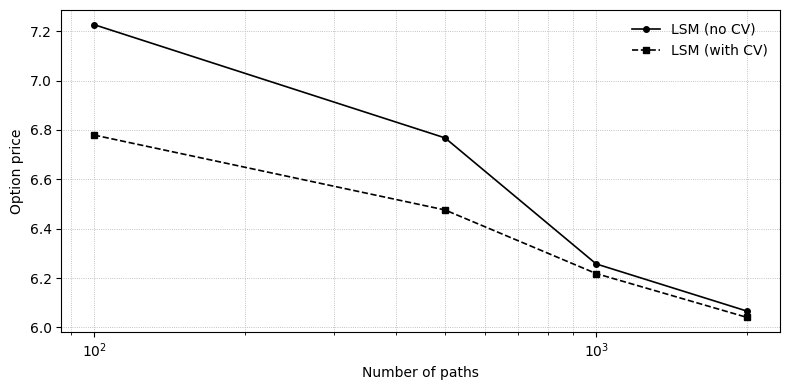

In [43]:
plt.figure(figsize=(8, 4))

plt.plot(
    n_paths_grid,
    lsm_no_cv,
    linestyle="-",
    marker="o",
    linewidth=1.2,
    markersize=4,
    color="black",
    label="LSM (no CV)",
)

plt.plot(
    n_paths_grid,
    lsm_cv,
    linestyle="--",
    marker="s",
    linewidth=1.2,
    markersize=4,
    color="black",
    label="LSM (with CV)",
)

plt.xscale("log")
plt.xlabel("Number of paths")
plt.ylabel("Option price")
plt.legend(frameon=False)
plt.grid(True, which="both", linestyle=":", linewidth=0.6)

plt.tight_layout()
#plt.savefig("/Users/quentinsenes/Desktop/lsm_convergence.png", dpi=300, bbox_inches="tight")
plt.show()

<a id='1_4'></a>
## 2.4 Anderson Broadie formulation: Longstaff–Schwartz, Upper  bound

### Andersen–Broadie dual formulation

We consider a Bermudan option on a discrete time grid
$$
0 = t_0 < t_1 < \dots < t_n = T,
$$
with discounted payoff
$$
X_k = e^{-r t_k} G(S_{t_k}).
$$
The Bermudan value (primal formulation) is
$$
V_0^{(n)} = \sup_{\tau \in \mathcal{T}^{(n)}} \mathbb{E}[X_\tau].
$$

---

### Dual representation (optimal stopping)

Optimal stopping duality yields the representation
$$
V_0^{(n)} =
\inf_{(M_k)} \mathbb{E}\left[\max_{0 \le k \le n} (X_k - M_k)\right],
$$
where $(M_k)$ is a discrete-time adapted martingale with $M_0 = 0$.

In particular, for any admissible martingale,
$$
V_0^{(n)} \le \mathbb{E}\left[\max_k (X_k - M_k)\right].
$$
This provides an upper bound on the price.

---

### Snell envelope and optimal martingale

The discrete Snell envelope is defined by
$$
V_n = X_n,
$$
$$
V_k = \max\left(X_k,\ \mathbb{E}[V_{k+1} \mid \mathcal{F}_{t_k}]\right).
$$
It is a supermartingale admitting a Doob decomposition
$$
V_k = V_0 + M_k - A_k,
$$
where the optimal martingale satisfies
$$
M_{k+1} - M_k
=
V_{k+1} - \mathbb{E}[V_{k+1} \mid \mathcal{F}_{t_k}].
$$

---

### Andersen–Broadie construction via LSM

The LSM method provides an approximation of the continuation value
$$
\widehat{C}_k \approx \mathbb{E}[V_{k+1} \mid \mathcal{F}_{t_k}],
$$
and an approximation of the value
$$
\widehat{V}_k = \max(X_k,\ \widehat{C}_k).
$$
An approximate martingale is then constructed by mimicking the Doob decomposition:
$$
\Delta \widehat{M}_{k+1}
=
\widehat{V}_{k+1}
-
\widehat{\mathbb{E}}\left[\widehat{V}_{k+1} \mid \mathcal{F}_{t_k}\right],
$$
with $\widehat{M}_0 = 0$.

---

### Dual estimator (upper bound)

For each Monte Carlo path,
$$
U^{(i)} = \max_{0 \le k \le n} \left(X_k^{(i)} - \widehat{M}_k^{(i)}\right).
$$
The dual estimator is
$$
\widehat{V}_0^{\text{dual}} = \frac{1}{M} \sum_{i=1}^M U^{(i)}.
$$

This estimator provides an upper bound on the Bermudan value (and hence on the American option price), complementing the lower bound obtained via LSM.

In [ ]:
# =============================================================================
#   DUAL ENGINE — ANDERSEN–BROADIE STYLE HIGH 
# =============================================================================
class AndersenBroadieEngine:
    """
    Andersen–Broadie / Rogers dual upper bound.

    Works with an existing engine providing:
      - engine.model.r
      - engine.simulate_paths(T, n_steps, n_paths, seed)

    Notation (all discounted-to-0):
      X0_t = payoff(S_t) * disc^t
      Fit betas[t] so that E[Y0_{t+1} | S_t] ≈ Phi(S_t) @ betas[t]
      Build Snell-like Y0 by:
          Y0_T = X0_T
          Y0_t = max( X0_t, Phi(S_t) betas[t] )
      Build martingale:
          M_0 = 0
          M_{t+1} = M_t + (Y0_{t+1} - Phi(S_t) betas[t])
      Upper bound:
          UB = E[ max_t (X0_t - M_t) ]
    """

    def __init__(self, engine):
        self.engine = engine
        self.model = engine.model

    def simulate_paths(self, T, n_steps, n_paths, seed=None):
        return self.engine.simulate_paths(T, n_steps, n_paths, seed)

    @staticmethod
    def _payoff(S: np.ndarray, K: float, opt_type: str) -> np.ndarray:
        if opt_type == "put":
            return np.maximum(K - S, 0.0)
        if opt_type == "call":
            return np.maximum(S - K, 0.0)
        raise ValueError("opt_type must be 'put' or 'call'")

    @staticmethod
    def _phi(s: np.ndarray, basis: str) -> np.ndarray:
        if basis == "poly2":
            return np.column_stack([np.ones_like(s), s, s**2])
        if basis == "poly3":
            return np.column_stack([np.ones_like(s), s, s**2, s**3])
        raise ValueError("basis must be 'poly2' or 'poly3'")

    @staticmethod
    def _fit_beta(X: np.ndarray, y: np.ndarray) -> np.ndarray:
        return np.linalg.lstsq(X, y, rcond=None)[0]

    @staticmethod
    def _clamp0(v: np.ndarray, on: bool) -> np.ndarray:
        return np.maximum(v, 0.0) if on else v

    def price_AB_high(
        self,
        K: float,
        T: float,
        n_steps: int,
        n_paths: int,
        opt_type: str = "put",
        basis: str = "poly2",
        seed: Optional[int] = 1,
        clamp_nonneg: bool = True,
    ) -> float:

        dt = T / n_steps
        disc = np.exp(-self.model.r * dt)

        # ===== Simulate Paths =====
        S = self.simulate_paths(T, n_steps, n_paths, seed)
        payoff = self._payoff(S, K, opt_type)
        X0 = payoff * (disc ** np.arange(n_steps + 1))[None, :]  # discounted to 0

        # ===== Backward construction of Y0 + store betas =====
        Y0 = np.zeros_like(X0)
        Y0[:, -1] = X0[:, -1]

        betas: list[np.ndarray | None] = [None] * (n_steps + 1)

        for t in range(n_steps - 1, -1, -1):
            X = self._phi(S[:, t], basis)
            y_next = Y0[:, t + 1]                  # discounted-to-0 target
            beta = self._fit_beta(X, y_next)
            betas[t] = beta

            Ey_next = X @ beta
            Ey_next = self._clamp0(Ey_next, clamp_nonneg)
            Y0[:, t] = np.maximum(X0[:, t], Ey_next)

        # ===== Martingale increments using same paths =====
        M = np.zeros_like(X0)
        for t in range(0, n_steps):
            X = self._phi(S[:, t], basis)
            EV = X @ betas[t]
            EV = self._clamp0(EV, clamp_nonneg)
            M[:, t + 1] = M[:, t] + (Y0[:, t + 1] - EV)

        UB_path = np.max(X0 - M, axis=1)
        return float(UB_path.mean())

In [46]:
### TEST ###
model = BlackScholes(S0=100.0, r=0.05, sigma=0.2)
lsm = PricingEngine(model)
ab  = AndersenBroadieEngine(lsm)

K = 100.0
T = 1.0
n_steps = 100

low = lsm.price_american_LSM_low(
    K=K, T=T, n_steps=n_steps,
    n_paths=100_000,
    type="put", basis="poly2", seed=1
)

high = ab.price_AB_high(
    K=K, T=T, n_steps=n_steps,
    n_paths=100_000,
    opt_type="put", basis="poly2",
    seed=1,
    clamp_nonneg=True
)

print("LOW :", low)
print("HIGH:", high)

LOW : 6.01591528821213
HIGH: 8.062830650361349


<a id='1_5'></a>
## 2.5 Plot : Convergence LSM vs AB

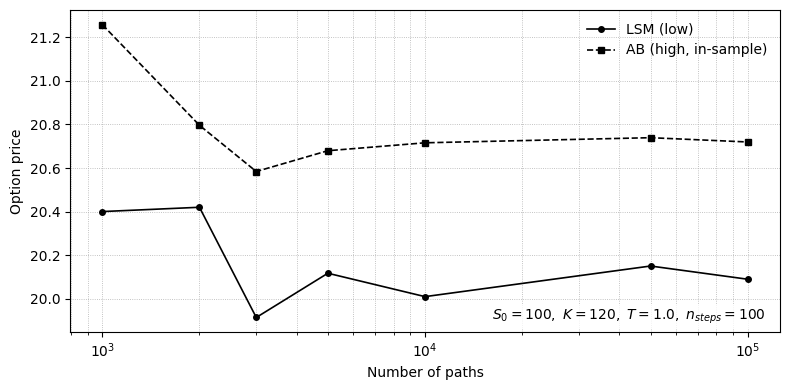

In [58]:
K = 120
T = 1.0
n_steps = 100

n_paths_grid = np.array([1_000, 2_000, 3_000, 5_000, 10_000, 50_000, 100_000])

lsm_vals = []
ab_vals  = []

base_seed = 1

for i, N in enumerate(n_paths_grid):
    N = int(N)
    seed_i = base_seed + i  # seed différent pour chaque N

    # LSM low
    lsm_vals.append(
        lsm.price_american_LSM_low(
            K=K, T=T, n_steps=n_steps,
            n_paths=N,
            type="put",
            basis="poly2",
            seed=seed_i
        )
    )

    # AB high (IN-SAMPLE, sans train/test)
    ab_vals.append(
        ab.price_AB_high(
            K=K, T=T, n_steps=n_steps,
            n_paths=N,
            opt_type="put",
            basis="poly2",
            seed=seed_i,
            clamp_nonneg=True
        )
    )

lsm_vals = np.array(lsm_vals)
ab_vals  = np.array(ab_vals)

plt.figure(figsize=(8, 4))

plt.plot(
    n_paths_grid,
    lsm_vals,
    linestyle="-",
    marker="o",
    linewidth=1.2,
    markersize=4,
    color="black",
    label="LSM (low)",
)

plt.plot(
    n_paths_grid,
    ab_vals,
    linestyle="--",
    marker="s",
    linewidth=1.2,
    markersize=4,
    color="black",
    label="AB (high, in-sample)",
)

plt.xscale("log")
plt.xlabel("Number of paths")
plt.ylabel("Option price")
plt.legend(frameon=False)
plt.grid(True, which="both", linestyle=":", linewidth=0.6)

plt.tight_layout()
# --- Paramètres option (bas droite) ---
param_text = rf"$S_0={100},\ K={K},\ T={T},\ n_{{steps}}={n_steps}$"

plt.gca().text(
    0.98, 0.02, param_text,
    transform=plt.gca().transAxes,
    ha="right", va="bottom",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.25", facecolor="white", edgecolor="none", alpha=0.8),
)

plt.savefig("/Users/quentinsenes/Desktop/lsm_ab_convergence.png", dpi=300, bbox_inches="tight")
plt.show()

<a id='2'></a>
# 3. PDE :